In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
tf.keras.backend.set_floatx("float64")
 
class DNModel(tf.keras.Model):
    def __init__(self):
        super(DNModel, self).__init__()

        self.dense1 = tf.keras.layers.Dense(32)
        self.dense2 = tf.keras.layers.Dense(32)
        self.out = tf.keras.layers.Dense(1)

    def call(self, x):
        x = tf.nn.tanh(self.dense1(x))
        x = tf.nn.tanh(self.dense2(x))

        return tf.math.exp(self.out(x))

    
    
    
@tf.function
def loss(model, x):
    n = x.shape[1]
    _x = tf.unstack(x, axis=1)
    _x_ = [tf.expand_dims(tmp, axis = 1) for tmp in _x]

    _x2 = tf.transpose(tf.stack(_x_))[0]


    psi = model(_x2)
    d_psi = [tf.squeeze(tf.gradients(psi, tmp)) for tmp in _x]
    d2_psi = 0
    for ii in range(n):
        d2_psi += tf.stack(tf.gradients(d_psi[ii], _x_[ii]))[0]
    
    lap = 1/psi*(d2_psi)
    
    E_L = -0.5*lap + 0.5*tf.reshape(tf.reduce_sum(x**2, axis=1), (-1,1))
    #E_L += tf.reshape(tf.reduce_sum(1/tf.math.sqrt((x[:,:2] - x[:,2:])**2 + 0.1**2), axis=1), (-1,1))
    E_L = tf.stop_gradient(E_L)
    E = tf.math.reduce_mean(E_L)
    
    psi_detach = tf.stop_gradient(psi)
    return E, 2*(tf.math.reduce_mean(psi/psi_detach*E_L) - tf.math.reduce_mean(psi/psi_detach)*E)


@tf.function
def grad(model, x):
    with tf.GradientTape() as tape:
        E, loss_value = loss(model, x)

    return E, tape.gradient(loss_value, model.trainable_variables)



def sample(model, N, n):
    total = 0
    x_old = tf.random.uniform((N, 4), minval=-2, maxval=2, dtype=tf.dtypes.float64)
    
    psi_old = model(x_old).numpy()
    
    for i in range(n):
        x_new = x_old + 2*tf.random.uniform((N, 4), minval=-1, maxval=1, dtype=tf.dtypes.float64)
        psi_new = model(x_new).numpy()
      
    
        U = np.random.uniform(0, 1, (N,1))
        mask = ((psi_new/psi_old)**2 > U)[:,0] #vectorized acceptance criterion
        x_old = x_old.numpy()
        x_new = x_new.numpy()
        
        x_old[mask]   = x_new[mask]  #move walkers
        psi_old[mask] = psi_new[mask]
        x_old = tf.convert_to_tensor(x_old, dtype=tf.dtypes.float64)
        total += np.sum(mask)
    
    return x_old, total

In [3]:
tf.random.set_seed(42)
np.random.seed(42)
model = DNModel()
optimizer = tf.keras.optimizers.Adam(0.01)
energy = []

In [4]:
N = 5000
num_epochs = 3000

for epoch in range(num_epochs):
    x = sample(model, N, 20)[0]

    E, gradients = grad(model, x)
    energy.append(E)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if epoch%50 == 0: 
        print(f"epoch: {epoch}, Energy: {E}")

epoch: 0, Energy: 49.30512244524584
epoch: 50, Energy: 3.01343559002726
epoch: 100, Energy: 2.158184204374338
epoch: 150, Energy: 2.0694052546262274
epoch: 200, Energy: 2.0420904895295657
epoch: 250, Energy: 2.039511792249273
epoch: 300, Energy: 2.017800146243118
epoch: 350, Energy: 2.0148482056912136
epoch: 400, Energy: 2.013265823570356
epoch: 450, Energy: 2.0122206265690266
epoch: 500, Energy: 2.0083110555493215
epoch: 550, Energy: 2.0078438763908406
epoch: 600, Energy: 2.007270086756976
epoch: 650, Energy: 2.007984775938777
epoch: 700, Energy: 2.004234573377139
epoch: 750, Energy: 2.0057218562090693
epoch: 800, Energy: 2.0085415051892372
epoch: 850, Energy: 2.0050183078605115
epoch: 900, Energy: 2.005439435198673
epoch: 950, Energy: 2.003166025411547
epoch: 1000, Energy: 2.005020606065503
epoch: 1050, Energy: 2.005453864685855
epoch: 1100, Energy: 2.0063665705155422
epoch: 1150, Energy: 2.006153775696189
epoch: 1200, Energy: 2.0052794592715792
epoch: 1250, Energy: 2.001698171514515

KeyboardInterrupt: 

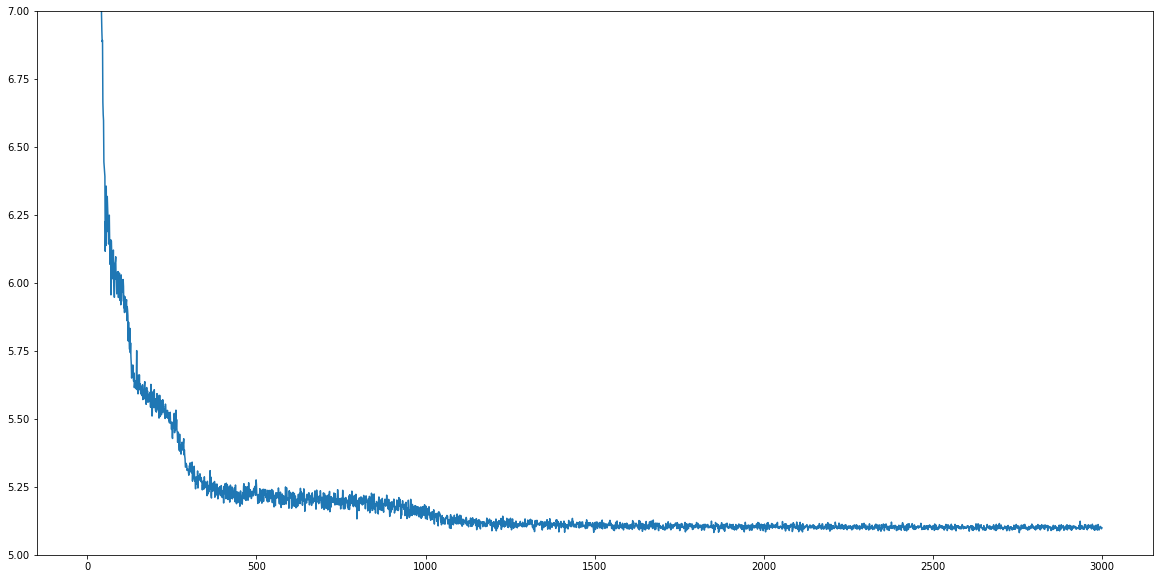

In [38]:
plt.figure(figsize=(20,10))
plt.plot(energy)
plt.ylim([5, 7])
plt.show()

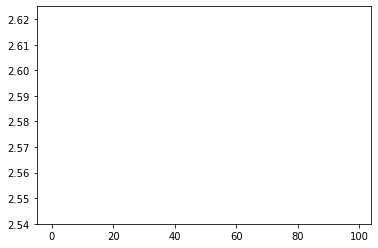

5.100328200038932


In [39]:
plt.plot(np.mean(np.split(np.array(energy), 100), axis=1))
plt.ylim([2.54, 2.625])
plt.show()
print(np.mean(np.array(energy[-300:])))

In [16]:
x_lin = np.linspace(-4, 4, 1000)
tf_x_lin = tf.convert_to_tensor(x_lin.reshape(-1,1), dtype=tf.dtypes.float64)

psi1 = model(tf_x_lin).numpy()[:, 0]
psi2 = np.exp(-0.5*x_lin**2)

plt.plot(x_lin, psi1**2/np.sum(psi1**2))
plt.plot(x_lin, psi2**2/np.sum(psi2**2), "--")
plt.show()

InvalidArgumentError: Matrix size-incompatible: In[0]: [1000,1], In[1]: [2,32] [Op:MatMul]

In [27]:
N = 1000000
x = sample(model, N, 10)[0]
E, gradients = grad(model, x)
print(E)

tf.Tensor(2.548745701728195, shape=(), dtype=float64)
